# Analyzing LightGBM and CatBoost Trading Signals

## Imports & Settings

In [1]:
%matplotlib inline

from time import time
from io import StringIO
import sys, os
import warnings
from itertools import product
from pathlib import Path
import numpy as np
import pandas as pd
import statsmodels.api as sm
import talib
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
import xgboost as xgb
from catboost import Pool, CatBoostClassifier

from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr, pearsonr

from alphalens.tears import (create_returns_tear_sheet,
                             create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens.performance import mean_return_by_quantile
from alphalens.plotting import plot_quantile_returns_bar
from alphalens.utils import get_clean_factor_and_forward_returns, rate_of_return

Using `alphalens` currently requires `pandas<=0.23.4`.

In [2]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV

In [3]:
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

In [4]:
YEAR = 252
idx = pd.IndexSlice

In [5]:
scope_params = ['lookahead', 'train_length', 'test_length']
daily_ic_metrics = ['daily_ic_mean', 'daily_ic_mean_n', 'daily_ic_median', 'daily_ic_median_n']
lgb_train_params = ['learning_rate', 'num_leaves', 'feature_fraction', 'min_data_in_leaf']
catboost_train_params = ['max_depth', 'min_child_samples']

## Collect Data

### LightGBM

#### Summary Metrics

In [6]:
lgb_metrics = []
with pd.HDFStore('data/tuning_lgb.h5') as store:
    for i, key in enumerate(
        [k[1:] for k in store.keys() if k[1:].startswith('metrics')]):
        _, t, train_length, test_length = key.split('/')[:4]
        attrs = {
            'lookahead': t,
            'train_length': train_length,
            'test_length': test_length
        }
        s = store[key].to_dict()
        s.update(attrs)
        if i == 0:
            lgb_metrics = pd.Series(s).to_frame(i)
        else:
            lgb_metrics[i] = pd.Series(s)

id_vars = scope_params + lgb_train_params + daily_ic_metrics
lgb_metrics = pd.melt(lgb_metrics.T.drop('t', axis=1), 
                  id_vars=id_vars, 
                  value_name='ic', 
                  var_name='boost_rounds').dropna().apply(pd.to_numeric)

In [7]:
lgb_metrics.to_hdf('data/model_tuning.h5', 'lgb/metrics')
lgb_metrics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2457 entries, 0 to 2456
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lookahead          2457 non-null   int64  
 1   train_length       2457 non-null   int64  
 2   test_length        2457 non-null   int64  
 3   learning_rate      2457 non-null   float64
 4   num_leaves         2457 non-null   float64
 5   feature_fraction   2457 non-null   float64
 6   min_data_in_leaf   2457 non-null   float64
 7   daily_ic_mean      2457 non-null   float64
 8   daily_ic_mean_n    2457 non-null   float64
 9   daily_ic_median    2457 non-null   float64
 10  daily_ic_median_n  2457 non-null   float64
 11  boost_rounds       2457 non-null   int64  
 12  ic                 2457 non-null   float64
dtypes: float64(9), int64(4)
memory usage: 268.7 KB


In [8]:
lgb_metrics.groupby(scope_params).size()

lookahead  train_length  test_length
1          756           63             351
           1134          63             486
5          756           63             324
           1134          63             486
21         756           63             324
           1134          63             486
dtype: int64

#### Information Coefficient by Day

In [9]:
int_cols = ['lookahead', 'train_length', 'test_length', 'boost_rounds']

In [10]:
lgb_ic = []
with pd.HDFStore('data/tuning_lgb.h5') as store:
    keys = [k[1:] for k in store.keys()]
    for key in keys:
        _, t, train_length, test_length = key.split('/')[:4]
        if key.startswith('daily_ic'):
            df = (store[key]
                  .drop(['boosting', 'objective', 'verbose'], axis=1)
                 .assign(lookahead=t, 
                         train_length=train_length, 
                         test_length=test_length))
            lgb_ic.append(df)
    lgb_ic = pd.concat(lgb_ic).reset_index()

In [11]:
id_vars = ['date'] + scope_params + lgb_train_params
lgb_ic = pd.melt(lgb_ic, 
                 id_vars=id_vars, 
                 value_name='ic', 
                 var_name='boost_rounds').dropna()
lgb_ic.loc[:, int_cols] = lgb_ic.loc[:, int_cols].astype(int)

In [12]:
lgb_ic.to_hdf('data/model_tuning.h5', 'lgb/ic')
lgb_ic.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1564369 entries, 0 to 1788695
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   date              1564369 non-null  datetime64[ns]
 1   lookahead         1564369 non-null  int64         
 2   train_length      1564369 non-null  int64         
 3   test_length       1564369 non-null  int64         
 4   learning_rate     1564369 non-null  float64       
 5   num_leaves        1564369 non-null  int64         
 6   feature_fraction  1564369 non-null  float64       
 7   min_data_in_leaf  1564369 non-null  int64         
 8   boost_rounds      1564369 non-null  int64         
 9   ic                1564369 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(6)
memory usage: 131.3 MB


In [13]:
lgb_ic_avg = lgb_ic.groupby(id_vars[1:] + ['boost_rounds']).ic.mean().to_frame('ic').reset_index()
lgb_ic_avg.to_hdf('data/model_tuning.h5', 'lgb/ic_avg')
lgb_ic_avg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3105 entries, 0 to 3104
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lookahead         3105 non-null   int64  
 1   train_length      3105 non-null   int64  
 2   test_length       3105 non-null   int64  
 3   learning_rate     3105 non-null   float64
 4   num_leaves        3105 non-null   int64  
 5   feature_fraction  3105 non-null   float64
 6   min_data_in_leaf  3105 non-null   int64  
 7   boost_rounds      3105 non-null   int64  
 8   ic                3105 non-null   float64
dtypes: float64(3), int64(6)
memory usage: 218.4 KB


In [14]:
lgb_ic = pd.read_hdf('data/model_tuning.h5', 'lgb/ic')
lgb_ic_avg = pd.read_hdf('data/model_tuning.h5', 'lgb/ic_avg')

### CatBoost

#### Summary Metrics

In [44]:
catboost_metrics = []
with pd.HDFStore('data/tuning_catboost.h5') as store:
    for i, key in enumerate(
            [k[1:] for k in store.keys() if k[1:].startswith('metrics')]):
        _, t, train_length, test_length = key.split('/')[:4]
        attrs = {
            'lookahead'   : t,
            'train_length': train_length,
            'test_length' : test_length
        }
        s = store[key].to_dict()
        s.update(attrs)
        if i == 0:
            catboost_metrics = pd.Series(s).to_frame(i)
        else:
            catboost_metrics[i] = pd.Series(s)

id_vars = scope_params + catboost_train_params + daily_ic_metrics
catboost_metrics = pd.melt(catboost_metrics.T.drop('t', axis=1),
                           id_vars=id_vars,
                           value_name='ic',
                           var_name='boost_rounds').dropna().apply(pd.to_numeric)

In [45]:
catboost_metrics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1176 entries, 0 to 1175
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lookahead          1176 non-null   int64  
 1   train_length       1176 non-null   int64  
 2   test_length        1176 non-null   int64  
 3   max_depth          1176 non-null   float64
 4   min_child_samples  1176 non-null   float64
 5   daily_ic_mean      1176 non-null   float64
 6   daily_ic_mean_n    1176 non-null   float64
 7   daily_ic_median    1176 non-null   float64
 8   daily_ic_median_n  1176 non-null   float64
 9   boost_rounds       1176 non-null   int64  
 10  ic                 1176 non-null   float64
dtypes: float64(7), int64(4)
memory usage: 110.2 KB


In [46]:
catboost_metrics.groupby(scope_params).size()

lookahead  train_length  test_length
1          252           21             168
           756           63             168
           1134          63             168
5          252           21             168
           756           63             168
21         252           63             168
           756           63             168
dtype: int64

#### Daily Information Coefficient

In [47]:
catboost_ic = []
with pd.HDFStore('data/tuning_catboost.h5') as store:
    keys = [k[1:] for k in store.keys()]
    for key in keys:
        _, t, train_length, test_length = key.split('/')[:4]
        if key.startswith('daily_ic'):
            df = (store[key].drop('task_type', axis=1)
                 .assign(lookahead=t,
                         train_length=train_length,
                         test_length=test_length))
            catboost_ic.append(df)
    catboost_ic = pd.concat(catboost_ic).reset_index()

In [48]:
id_vars = ['date'] + scope_params + catboost_train_params
catboost_ic = pd.melt(catboost_ic, 
                      id_vars=id_vars, 
                      value_name='ic', 
                      var_name='boost_rounds').dropna()
catboost_ic.loc[:, int_cols] = catboost_ic.loc[:, int_cols].astype(int)

In [49]:
catboost_ic.to_hdf('data/model_tuning.h5', 'catboost/ic')
catboost_ic.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 592704 entries, 0 to 592703
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   date               592704 non-null  datetime64[ns]
 1   lookahead          592704 non-null  int64         
 2   train_length       592704 non-null  int64         
 3   test_length        592704 non-null  int64         
 4   max_depth          592704 non-null  int64         
 5   min_child_samples  592704 non-null  int64         
 6   boost_rounds       592704 non-null  int64         
 7   ic                 592704 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(6)
memory usage: 40.7 MB


In [50]:
catboost_ic_avg = catboost_ic.groupby(id_vars[1:] + ['boost_rounds']).ic.mean().to_frame('ic').reset_index()
catboost_ic_avg.to_hdf('data/model_tuning.h5', 'catboost/ic_avg')
catboost_ic_avg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lookahead          1176 non-null   int64  
 1   train_length       1176 non-null   int64  
 2   test_length        1176 non-null   int64  
 3   max_depth          1176 non-null   int64  
 4   min_child_samples  1176 non-null   int64  
 5   boost_rounds       1176 non-null   int64  
 6   ic                 1176 non-null   float64
dtypes: float64(1), int64(6)
memory usage: 64.4 KB


In [51]:
catboost_ic = pd.read_hdf('data/model_tuning.h5', 'catboost/ic')
catboost_ic_avg = pd.read_hdf('data/model_tuning.h5', 'catboost/ic_avg')

## Daily vs Overall Information Coefficient

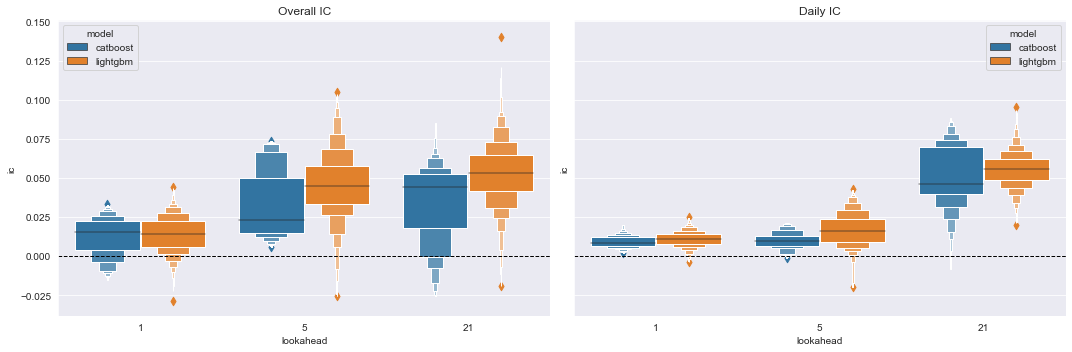

In [53]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)
sns.boxenplot(x='lookahead', y='ic', hue='model',
              data=catboost_metrics.assign(model='catboost')
              .append(lgb_metrics.assign(model='lightgbm')), ax=axes[0])
axes[0].axhline(0, ls='--', lw=1, c='k')
axes[0].set_title('Overall IC')
sns.boxenplot(x='lookahead', y='ic', hue='model',
              data=catboost_ic_avg.assign(model='catboost')
              .append(lgb_ic_avg.assign(model='lightgbm')), ax=axes[1])
axes[1].axhline(0, ls='--', lw=1, c='k')
axes[1].set_title('Daily IC')
fig.tight_layout()
fig.savefig('figures/lgb_cb_ic', dpi=300);

## HyperParameter Impact: Linear Regression

In [93]:
lin_reg = {}
for t in [1, 21]:
    df_ = lgb_ic[lgb_ic.lookahead==t]
    y, X = df_.ic, df_.drop(['ic'], axis=1)
    X = sm.add_constant(pd.get_dummies(X, columns=X.columns, drop_first=True))
    model = sm.OLS(endog=y, exog=X)
    lin_reg[t] = model.fit()
    s = lin_reg[t].summary()
    coefs = pd.read_csv(StringIO(s.tables[1].as_csv())).rename(columns=lambda x: x.strip())
    coefs.columns = ['variable', 'coef', 'std_err', 't', 'p_value', 'ci_low', 'ci_high']
    coefs.to_csv(f'results/linreg_result_{t:02}.csv', index=False)

In [94]:
def visualize_lr_result(model, ax):
    ci = model.conf_int()
    errors = ci[1].sub(ci[0]).div(2)

    coefs = (model.params.to_frame('coef').assign(error=errors)
             .reset_index().rename(columns={'index': 'variable'}))
    coefs = coefs[~coefs['variable'].str.startswith('date')&(coefs.variable!='const')]

    coefs.plot(x='variable', y='coef', kind='bar', 
                 ax=ax, color='none', capsize=3,
                 yerr='error', legend=False)
    ax.set_ylabel('IC')
    ax.set_xlabel('')
    ax.scatter(x=pd.np.arange(len(coefs)), marker='_', s=120, y=coefs['coef'], color='black')
    ax.axhline(y=0, linestyle='--', color='black', linewidth=1)
    ax.xaxis.set_ticks_position('none')

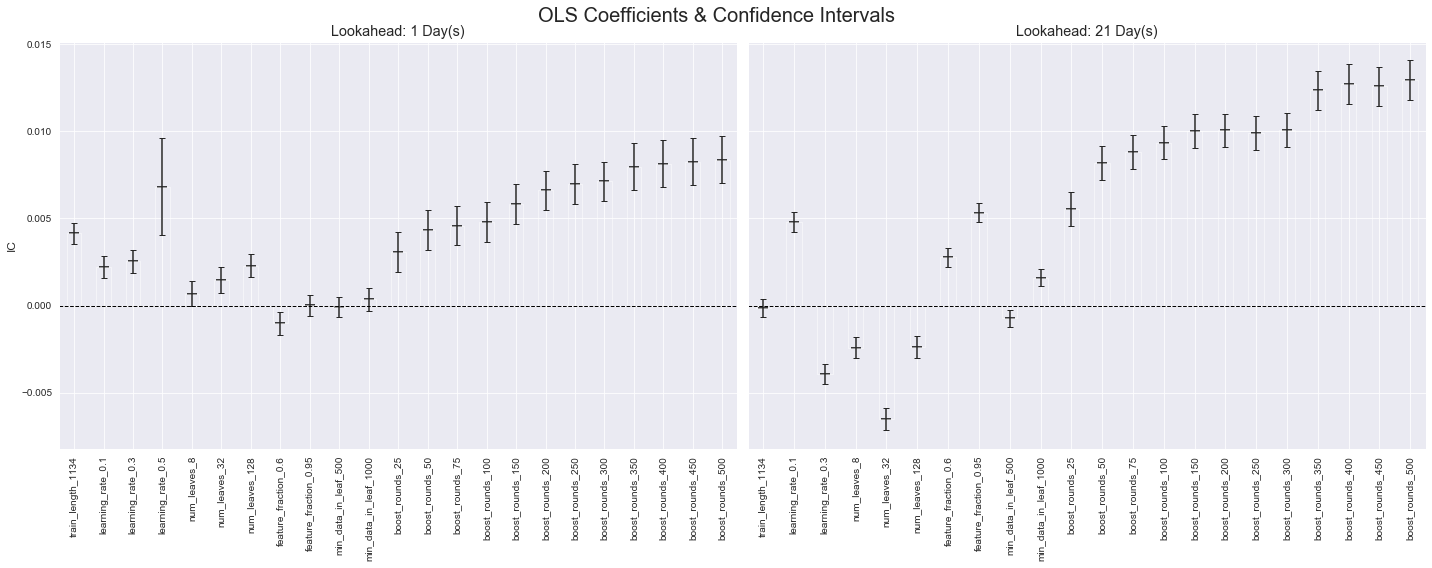

In [95]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharey=True)
axes = axes.flatten()
for i, t in enumerate([1, 21]):
    visualize_lr_result(lin_reg[t], axes[i])
    axes[i].set_title(f'Lookahead: {t} Day(s)')
fig.suptitle('OLS Coefficients & Confidence Intervals', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.92)
fig.savefig('figures/ols_coefs', dpi=300);

## Best Parameters

### LightGBM

In [24]:
group_cols = scope_params + lgb_train_params + ['boost_rounds']
lgb_ic_avg.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))

lookahead  train_length  test_length  learning_rate  num_leaves  \
595           1          1134           63           0.01         128   
596           1          1134           63           0.01         128   
610           1          1134           63           0.01         128   
1569          5          1134           63           0.10           4   
1568          5          1134           63           0.10           4   
1570          5          1134           63           0.10           4   
2260         21           756           63           0.10         128   
2261         21           756           63           0.10         128   
2262         21           756           63           0.10         128   

      feature_fraction  min_data_in_leaf  boost_rounds        ic  
595               0.95               250           400  0.024674  
596               0.95               250           450  0.024292  
610               0.95               500           500  0.024198  
1569              0.30               500           400  0.042814  
1568              0.30               500           350  0.041771  
1570              0.30               500           450  0.041151  
2260              0.95              1000            25  0.095405  
2261              0.95              1000            50  0.091278  
2262              0.95              1000            75  0.089669

In [25]:
lgb_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))
lgb_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic')).to_csv('results/best_lgb_model.csv', index=False)

In [98]:
lgb_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'daily_ic_mean'))

lookahead  train_length  test_length  learning_rate  num_leaves  \
267          1          1134           63           0.01       128.0   
540          1          1134           63           0.01       128.0   
813          1          1134           63           0.01       128.0   
63           5          1134           63           0.10         4.0   
336          5          1134           63           0.10         4.0   
609          5          1134           63           0.10         4.0   
120         21           756           63           0.10       128.0   
393         21           756           63           0.10       128.0   
666         21           756           63           0.10       128.0   

     feature_fraction  min_data_in_leaf  daily_ic_mean  daily_ic_mean_n  \
267              0.95             250.0       0.024674            400.0   
540              0.95             250.0       0.024674            400.0   
813              0.95             250.0       0.024674            400.0   
63               0.30             500.0       0.042814            400.0   
336              0.30             500.0       0.042814            400.0   
609              0.30             500.0       0.042814            400.0   
120              0.95            1000.0       0.095405             25.0   
393              0.95            1000.0       0.095405             25.0   
666              0.95            1000.0       0.095405             25.0   

     daily_ic_median  daily_ic_median_n  boost_rounds        ic  
267         0.023807              500.0            10 -0.002447  
540         0.023807              500.0            25 -0.000077  
813         0.023807              500.0            50 -0.000030  
63          0.038330              500.0            10  0.055980  
336         0.038330              500.0            25  0.055506  
609         0.038330              500.0            50  0.045449  
120         0.099453               25.0            10  0.082795  
393         0.099453               25.0            25  0.076064  
666         0.099453               25.0            50  0.072365

### CatBoost

In [99]:
group_cols = scope_params + catboost_train_params + ['boost_rounds']
catboost_ic_avg.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))

lookahead  train_length  test_length  max_depth  min_child_samples  \
20          1          1134           63          7                 20   
19          1          1134           63          7                 20   
22          1          1134           63          7                 20   
48          5          1134           63          9                500   
50          5          1134           63          9                500   
51          5          1134           63          9                500   
71         21          1134           63          5                 20   
72         21          1134           63          5                 20   
70         21          1134           63          5                 20   

    boost_rounds        ic  
20           300  0.015448  
19           200  0.015331  
22           500  0.014665  
48           300  0.037996  
50           500  0.037120  
51           600  0.036925  
71            25  0.066145  
72            50  0.060928  
70            10  0.053437

In [100]:
catboost_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))

lookahead  train_length  test_length  max_depth  min_child_samples  \
41          1          1134           63        7.0               20.0   
47          1          1134           63        7.0               20.0   
35          1          1134           63        7.0               20.0   
31          5          1134           63        9.0              500.0   
37          5          1134           63        9.0              500.0   
25          5          1134           63        9.0              500.0   
3          21          1134           63        5.0               20.0   
80         21           252           63        7.0               20.0   
74         21           252           63        7.0               20.0   

    daily_ic_mean  daily_ic_mean_n  daily_ic_median  daily_ic_median_n  \
41       0.015448            300.0         0.011758              600.0   
47       0.015448            300.0         0.011758              600.0   
35       0.015448            300.0         0.011758              600.0   
31       0.037996            300.0         0.032535              300.0   
37       0.037996            300.0         0.032535              300.0   
25       0.037996            300.0         0.032535              300.0   
3        0.066145             25.0         0.064938               50.0   
80       0.013419           1000.0         0.021997             1000.0   
74       0.013419           1000.0         0.021997             1000.0   

    boost_rounds        ic  
41           300  0.030235  
47           400  0.028657  
35           200  0.027856  
31           200  0.087154  
37           300  0.085816  
25           100  0.083290  
3             10  0.020251  
80          1000  0.018330  
74           900  0.017255

In [101]:
catboost_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'daily_ic_mean'))

lookahead  train_length  test_length  max_depth  min_child_samples  \
5           1          1134           63        7.0               20.0   
11          1          1134           63        7.0               20.0   
17          1          1134           63        7.0               20.0   
1           5          1134           63        9.0              500.0   
7           5          1134           63        9.0              500.0   
13          5          1134           63        9.0              500.0   
3          21          1134           63        5.0               20.0   
9          21          1134           63        5.0               20.0   
15         21          1134           63        5.0               20.0   

    daily_ic_mean  daily_ic_mean_n  daily_ic_median  daily_ic_median_n  \
5        0.015448            300.0         0.011758              600.0   
11       0.015448            300.0         0.011758              600.0   
17       0.015448            300.0         0.011758              600.0   
1        0.037996            300.0         0.032535              300.0   
7        0.037996            300.0         0.032535              300.0   
13       0.037996            300.0         0.032535              300.0   
3        0.066145             25.0         0.064938               50.0   
9        0.066145             25.0         0.064938               50.0   
15       0.066145             25.0         0.064938               50.0   

    boost_rounds        ic  
5             10  0.020085  
11            25  0.017902  
17            50  0.021303  
1             10  0.072069  
7             25  0.074811  
13            50  0.078954  
3             10  0.020251  
9             25 -0.013221  
15            50 -0.009092

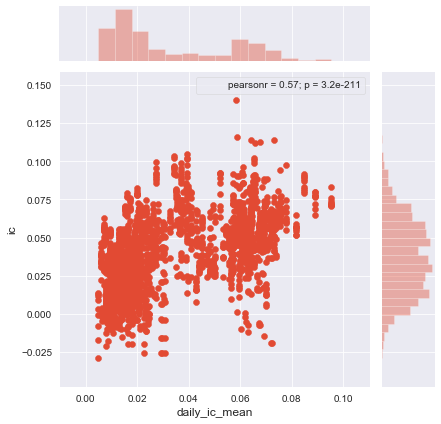

In [102]:
sns.jointplot(x=lgb_metrics.daily_ic_mean,y=lgb_metrics.ic).annotate(pearsonr);

### Visualization

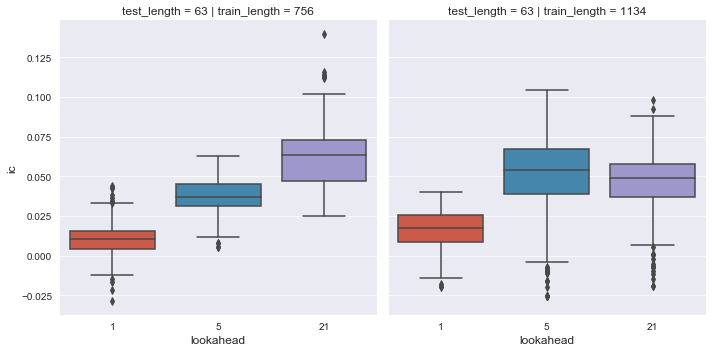

In [107]:
g = sns.catplot(x='lookahead', y='ic',
                col='train_length', row='test_length',
                data=lgb_metrics,
                kind='box')
g.savefig('figures/catplot_all_t', dpi=300)

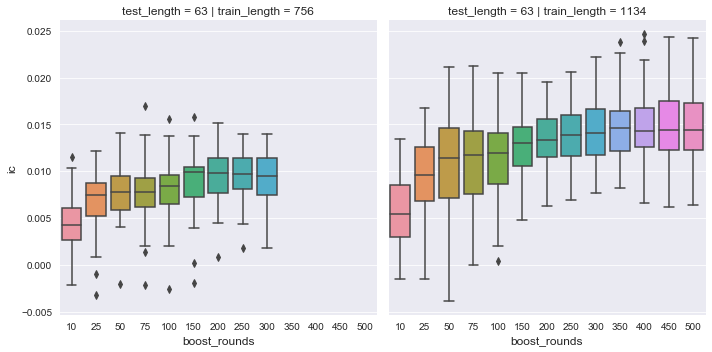

In [108]:
t=1
lgb_ic_avg
g=sns.catplot(x='boost_rounds',
            y='ic',
            col='train_length',
            row='test_length',
            data=lgb_ic_avg[lgb_ic_avg.lookahead == t],
            kind='box')

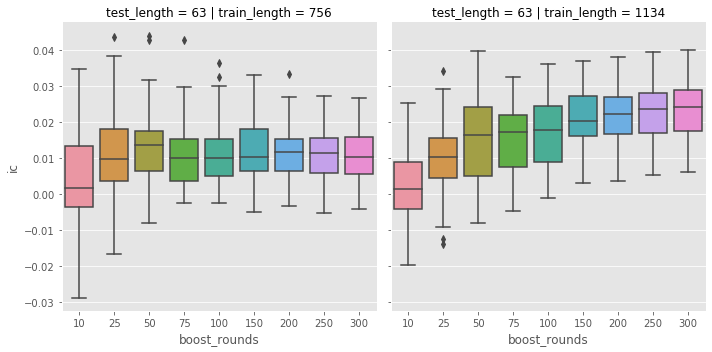

In [213]:
t = 1
g=sns.catplot(x='boost_rounds',
            y='ic',
            col='train_length',
            row='test_length',
            data=metrics[metrics.lookahead == t],
            kind='box')
# g.savefig('figures/catplot_05a', dpi=300);

In [110]:
lgb_ic_avg.nunique()

lookahead              3
train_length           2
test_length            1
learning_rate          4
num_leaves             4
feature_fraction       3
min_data_in_leaf       3
boost_rounds          13
ic                  3095
dtype: int64

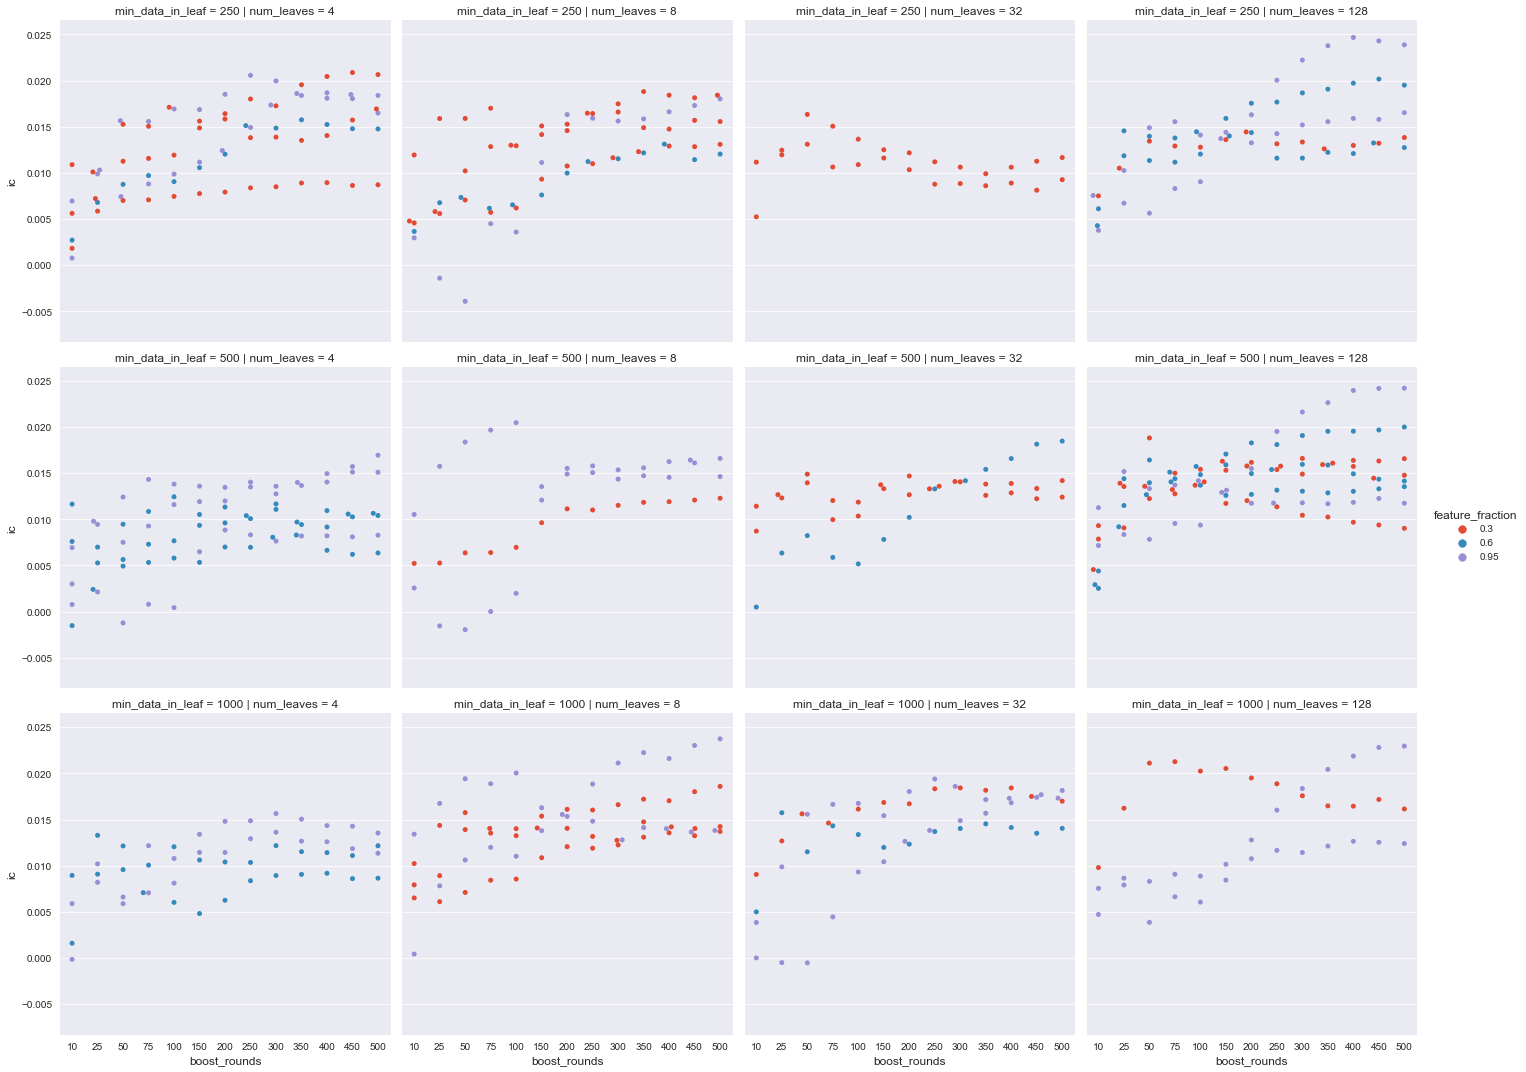

In [109]:
t = 1
train_length = 1134
test_length = 63
g = sns.catplot(
    x='boost_rounds',
    y='ic',
    col='num_leaves',
    hue='feature_fraction',
    row='min_data_in_leaf',
    data=lgb_ic_avg[(lgb_ic_avg.lookahead == t)
                      & (lgb_ic_avg.train_length == train_length) &
                      (lgb_ic_avg.test_length == test_length)],
    kind='swarm')
# g.savefig('figures/catplot_05b', dpi=300);

## AlphaLens Analysis

### LightGBM

#### Select Parameters

In [14]:
lgb_ic_avg = pd.read_hdf('data/model_tuning.h5', 'lgb/ic_avg')
lgb_ic_avg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3105 entries, 0 to 3104
Data columns (total 9 columns):
lookahead           3105 non-null int64
train_length        3105 non-null int64
test_length         3105 non-null int64
learning_rate       3105 non-null float64
num_leaves          3105 non-null int64
feature_fraction    3105 non-null float64
min_data_in_leaf    3105 non-null int64
boost_rounds        3105 non-null int64
ic                  3105 non-null float64
dtypes: float64(3), int64(6)
memory usage: 242.6 KB


In [15]:
def get_lgb_params(data, t=5, best=0):
    param_cols = scope_params[1:] + lgb_train_params + ['boost_rounds']
    df = data[data.lookahead==t].sort_values('ic', ascending=False).iloc[best]
    return df.loc[param_cols]

In [16]:
def get_lgb_key(t, p):
    key = f'{t}/{int(p.train_length)}/{int(p.test_length)}/{p.learning_rate}/'
    return key + f'{int(p.num_leaves)}/{p.feature_fraction}/{int(p.min_data_in_leaf)}'

In [17]:
best_params = get_lgb_params(lgb_ic_avg, t=1, best=0)
best_params

train_length        1134.00
test_length           63.00
learning_rate          0.01
num_leaves           128.00
feature_fraction       0.95
min_data_in_leaf     250.00
boost_rounds         400.00
Name: 595, dtype: float64

#### Plot rolling IC

In [70]:
def select_ic(params, ic_data, lookahead):
    return ic_data.loc[(ic_data.lookahead == lookahead) &
                       (ic_data.train_length == params.train_length) &
                       (ic_data.test_length == params.test_length) &
                       (ic_data.learning_rate == params.learning_rate) &
                       (ic_data.num_leaves == params.num_leaves) &
                       (ic_data.feature_fraction == params.feature_fraction) &
                       (ic_data.boost_rounds == params.boost_rounds), ['date', 'ic']].set_index('date')

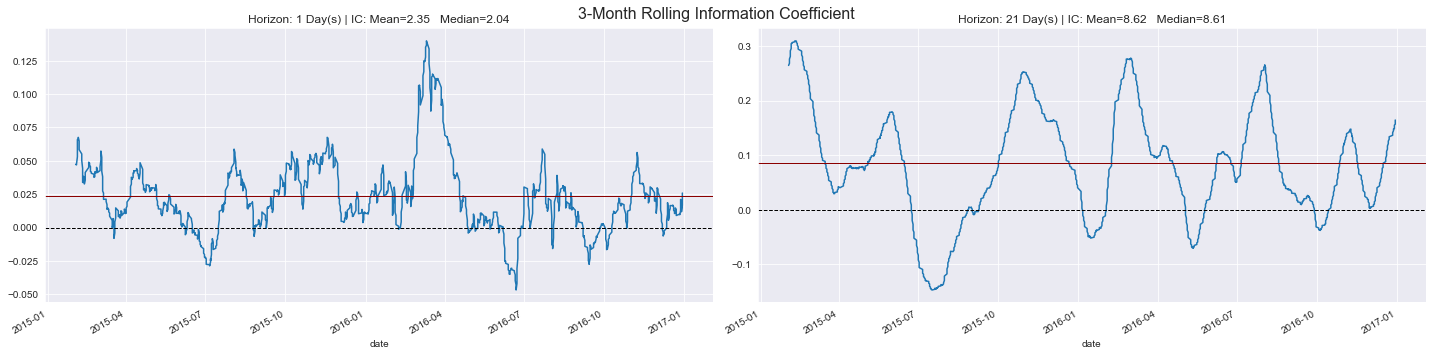

In [71]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes = axes.flatten()
for i, t in enumerate([1, 21]):
    params = get_lgb_params(lgb_ic_avg, t=t)
    data = select_ic(params, lgb_ic, lookahead=t).sort_index()
    rolling = data.rolling(63).ic.mean().dropna()
    avg = data.ic.mean()
    med = data.ic.median()
    rolling.plot(ax=axes[i], title=f'Horizon: {t} Day(s) | IC: Mean={avg*100:.2f}   Median={med*100:.2f}')
    axes[i].axhline(avg, c='darkred', lw=1)
    axes[i].axhline(0, ls='--', c='k', lw=1)

fig.suptitle('3-Month Rolling Information Coefficient', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.92)
fig.savefig('figures/rolling_ic_lgb', dpi=300);

#### Get Predictions

In [54]:
lookahead = 1
topn = 10
for best in range(topn):
    best_params = get_lgb_params(lgb_ic_avg, t=lookahead, best=best)
    key = get_lgb_key(lookahead, best_params)
    rounds = str(int(best_params.boost_rounds))
    if best == 0:
        best_predictions = pd.read_hdf('data/tuning_lgb.h5', 'predictions/' + key)
        best_predictions = best_predictions[rounds].to_frame(best)
    else:
        best_predictions[best] = pd.read_hdf('data/tuning_lgb.h5',
                                             'predictions/' + key)[rounds]
best_predictions = best_predictions.sort_index()

In [55]:
best_predictions.to_hdf('data/predictions.h5', f'lgb/train/{lookahead:02}')
best_predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 501310 entries, (A, 2015-01-02 00:00:00) to (ZION, 2016-12-30 00:00:00)
Data columns (total 10 columns):
0    501310 non-null float64
1    501310 non-null float64
2    501310 non-null float64
3    501310 non-null float64
4    501310 non-null float64
5    501310 non-null float64
6    501310 non-null float64
7    501310 non-null float64
8    501310 non-null float64
9    501310 non-null float64
dtypes: float64(10)
memory usage: 40.2+ MB


#### Get Trade Prices

Using next available prices.

In [116]:
def get_trade_prices(tickers):
    idx = pd.IndexSlice
    DATA_STORE = '../data/assets.h5'
    prices = (pd.read_hdf(DATA_STORE, 'quandl/wiki/prices').swaplevel().sort_index())
    prices.index.names = ['symbol', 'date']
    return (prices.loc[idx[tickers, '2015': '2017'], 'adj_open']
            .unstack('symbol')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [21]:
test_tickers = best_predictions.index.get_level_values('symbol').unique()

In [118]:
trade_prices = get_trade_prices(test_tickers)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 2015-01-02 00:00:00+00:00 to 2017-12-29 00:00:00+00:00
Columns: 995 entries, A to ZION
dtypes: float64(995)
memory usage: 5.7 MB


In [22]:
# trade_prices.to_hdf('model_tuning.h5', 'trade_prices/model_selection')
trade_prices = pd.read_hdf('data/model_tuning.h5', 'trade_prices/model_selection')

In [23]:
factor = best_predictions.iloc[:, :5].mean(1).dropna().tz_localize('UTC', level='date').swaplevel()

#### Create AlphaLens Inputs

In [28]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21))

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


#### Summary Tearsheet

Quantiles Statistics


min       max      mean       std   count    count %
factor_quantile                                                           
1               -0.043323  0.007629 -0.002025  0.003269  100296  20.006822
2               -0.013078  0.010640 -0.000747  0.002936  100247  19.997048
3               -0.008825  0.012310 -0.000009  0.002950  100223  19.992260
4               -0.008289  0.017452  0.000698  0.003072  100247  19.997048
5               -0.007450  0.052497  0.002109  0.003811  100296  20.006822

Returns Analysis


1D     5D    10D    21D
Ann. alpha                                      0.176  0.078  0.045  0.037
beta                                            0.089  0.152  0.192  0.198
Mean Period Wise Return Top Quantile (bps)      5.884  3.375  2.742  2.496
Mean Period Wise Return Bottom Quantile (bps)  -6.282 -3.603 -2.240 -1.946
Mean Period Wise Spread (bps)                  12.165  6.951  4.946  4.408

Information Analysis


1D     5D    10D    21D
IC Mean           0.020  0.021  0.022  0.034
IC Std.           0.126  0.136  0.141  0.140
Risk-Adjusted IC  0.162  0.158  0.156  0.246
t-stat(IC)        3.638  3.545  3.501  5.515
p-value(IC)       0.000  0.000  0.001  0.000
IC Skew           0.065  0.249  0.246  0.087
IC Kurtosis       0.970  1.544  0.567  0.740

Turnover Analysis


10D     1D    21D     5D
Quantile 1 Mean Turnover   0.721  0.634  0.770  0.654
Quantile 2 Mean Turnover   0.779  0.751  0.790  0.756
Quantile 3 Mean Turnover   0.783  0.763  0.791  0.769
Quantile 4 Mean Turnover   0.777  0.752  0.795  0.756
Quantile 5 Mean Turnover   0.695  0.622  0.738  0.640

1D     5D    10D    21D
Mean Factor Rank Autocorrelation  0.309  0.283  0.164  0.071

<Figure size 432x288 with 0 Axes>

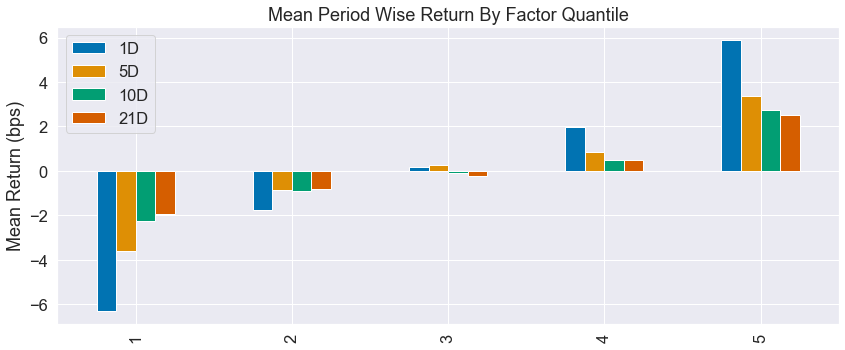

In [29]:
create_summary_tear_sheet(factor_data)

Quantiles Statistics


min       max      mean       std   count    count %
factor_quantile                                                           
1               -0.043323  0.007629 -0.002025  0.003269  100296  20.006822
2               -0.013078  0.010640 -0.000747  0.002936  100247  19.997048
3               -0.008825  0.012310 -0.000009  0.002950  100223  19.992260
4               -0.008289  0.017452  0.000698  0.003072  100247  19.997048
5               -0.007450  0.052497  0.002109  0.003811  100296  20.006822

Returns Analysis


1D     5D    10D    21D
Ann. alpha                                      0.176  0.078  0.045  0.037
beta                                            0.089  0.152  0.192  0.198
Mean Period Wise Return Top Quantile (bps)      5.884  3.375  2.742  2.496
Mean Period Wise Return Bottom Quantile (bps)  -6.282 -3.603 -2.240 -1.946
Mean Period Wise Spread (bps)                  12.165  6.951  4.946  4.408

<Figure size 432x288 with 0 Axes>

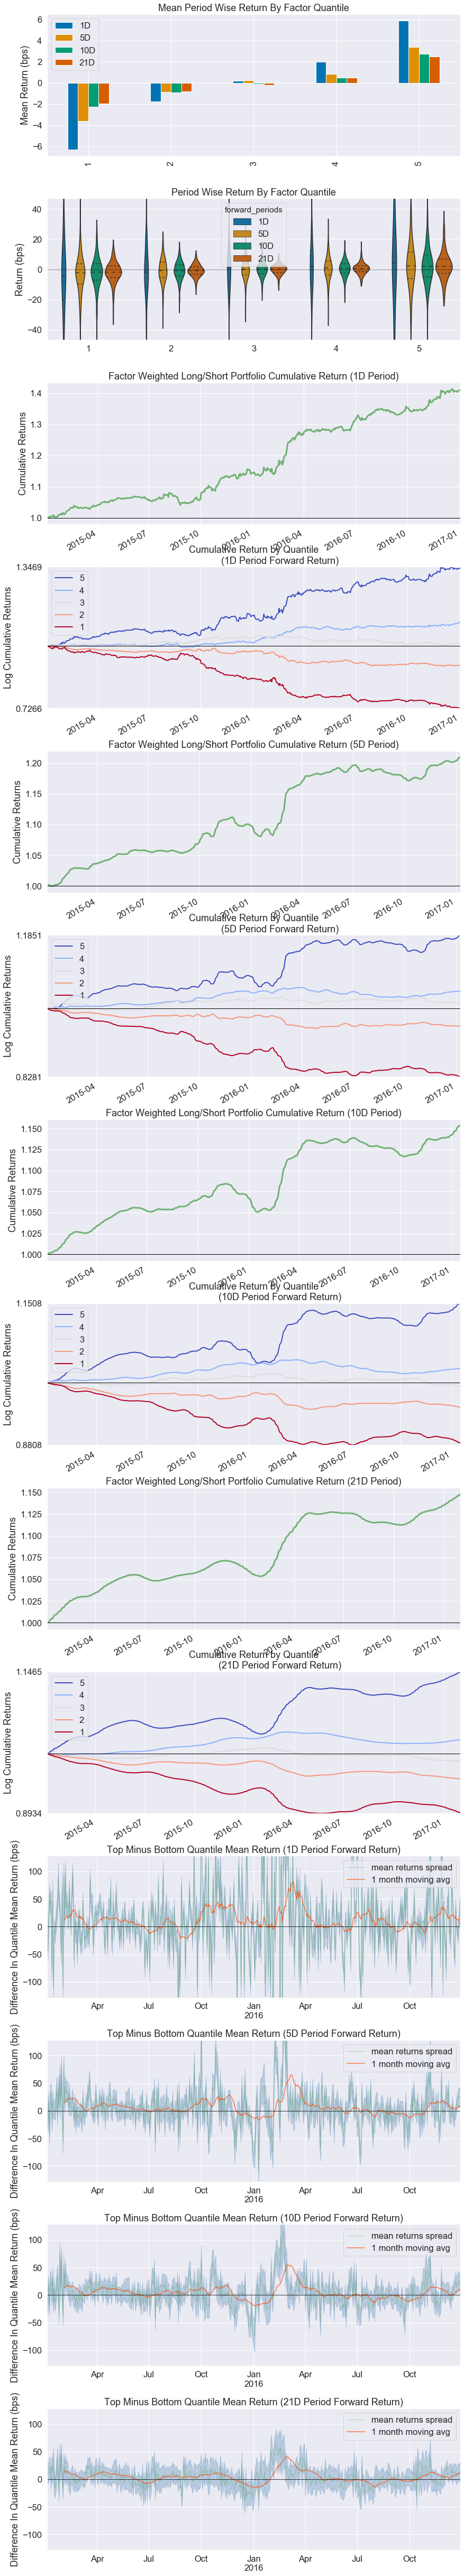

Information Analysis


1D     5D    10D    21D
IC Mean           0.020  0.021  0.022  0.034
IC Std.           0.126  0.136  0.141  0.140
Risk-Adjusted IC  0.162  0.158  0.156  0.246
t-stat(IC)        3.638  3.545  3.501  5.515
p-value(IC)       0.000  0.000  0.001  0.000
IC Skew           0.065  0.249  0.246  0.087
IC Kurtosis       0.970  1.544  0.567  0.740

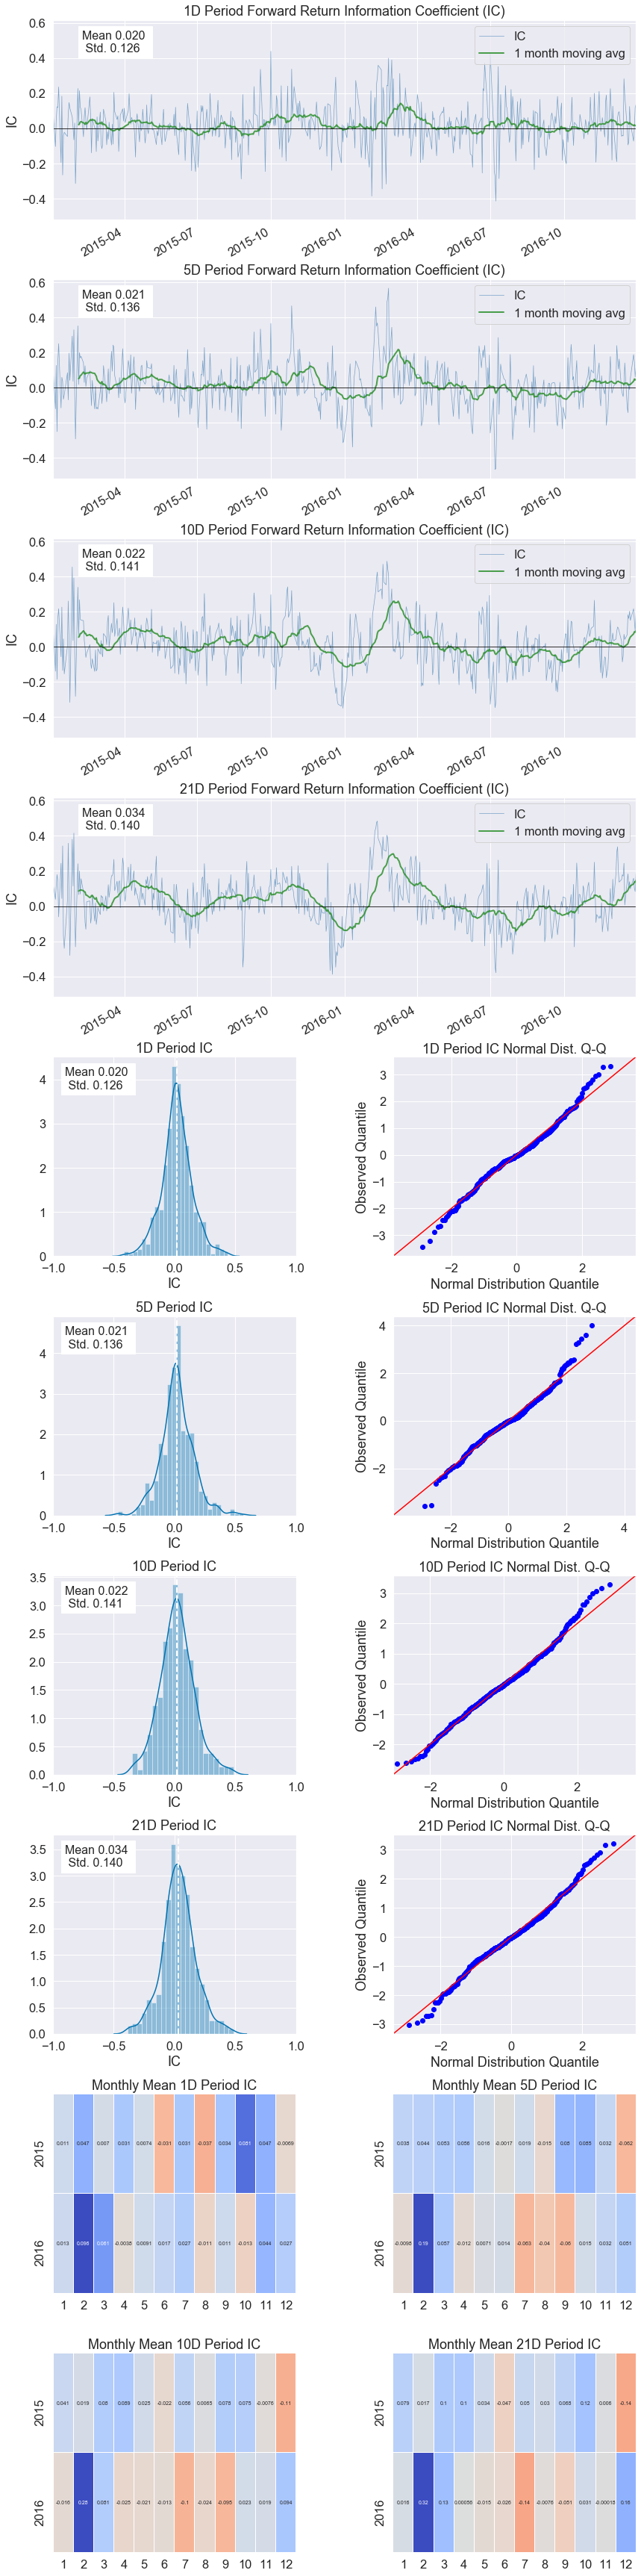

Turnover Analysis


10D     1D    21D     5D
Quantile 1 Mean Turnover   0.721  0.634  0.770  0.654
Quantile 2 Mean Turnover   0.779  0.751  0.790  0.756
Quantile 3 Mean Turnover   0.783  0.763  0.791  0.769
Quantile 4 Mean Turnover   0.777  0.752  0.795  0.756
Quantile 5 Mean Turnover   0.695  0.622  0.738  0.640

1D     5D    10D    21D
Mean Factor Rank Autocorrelation  0.309  0.283  0.164  0.071

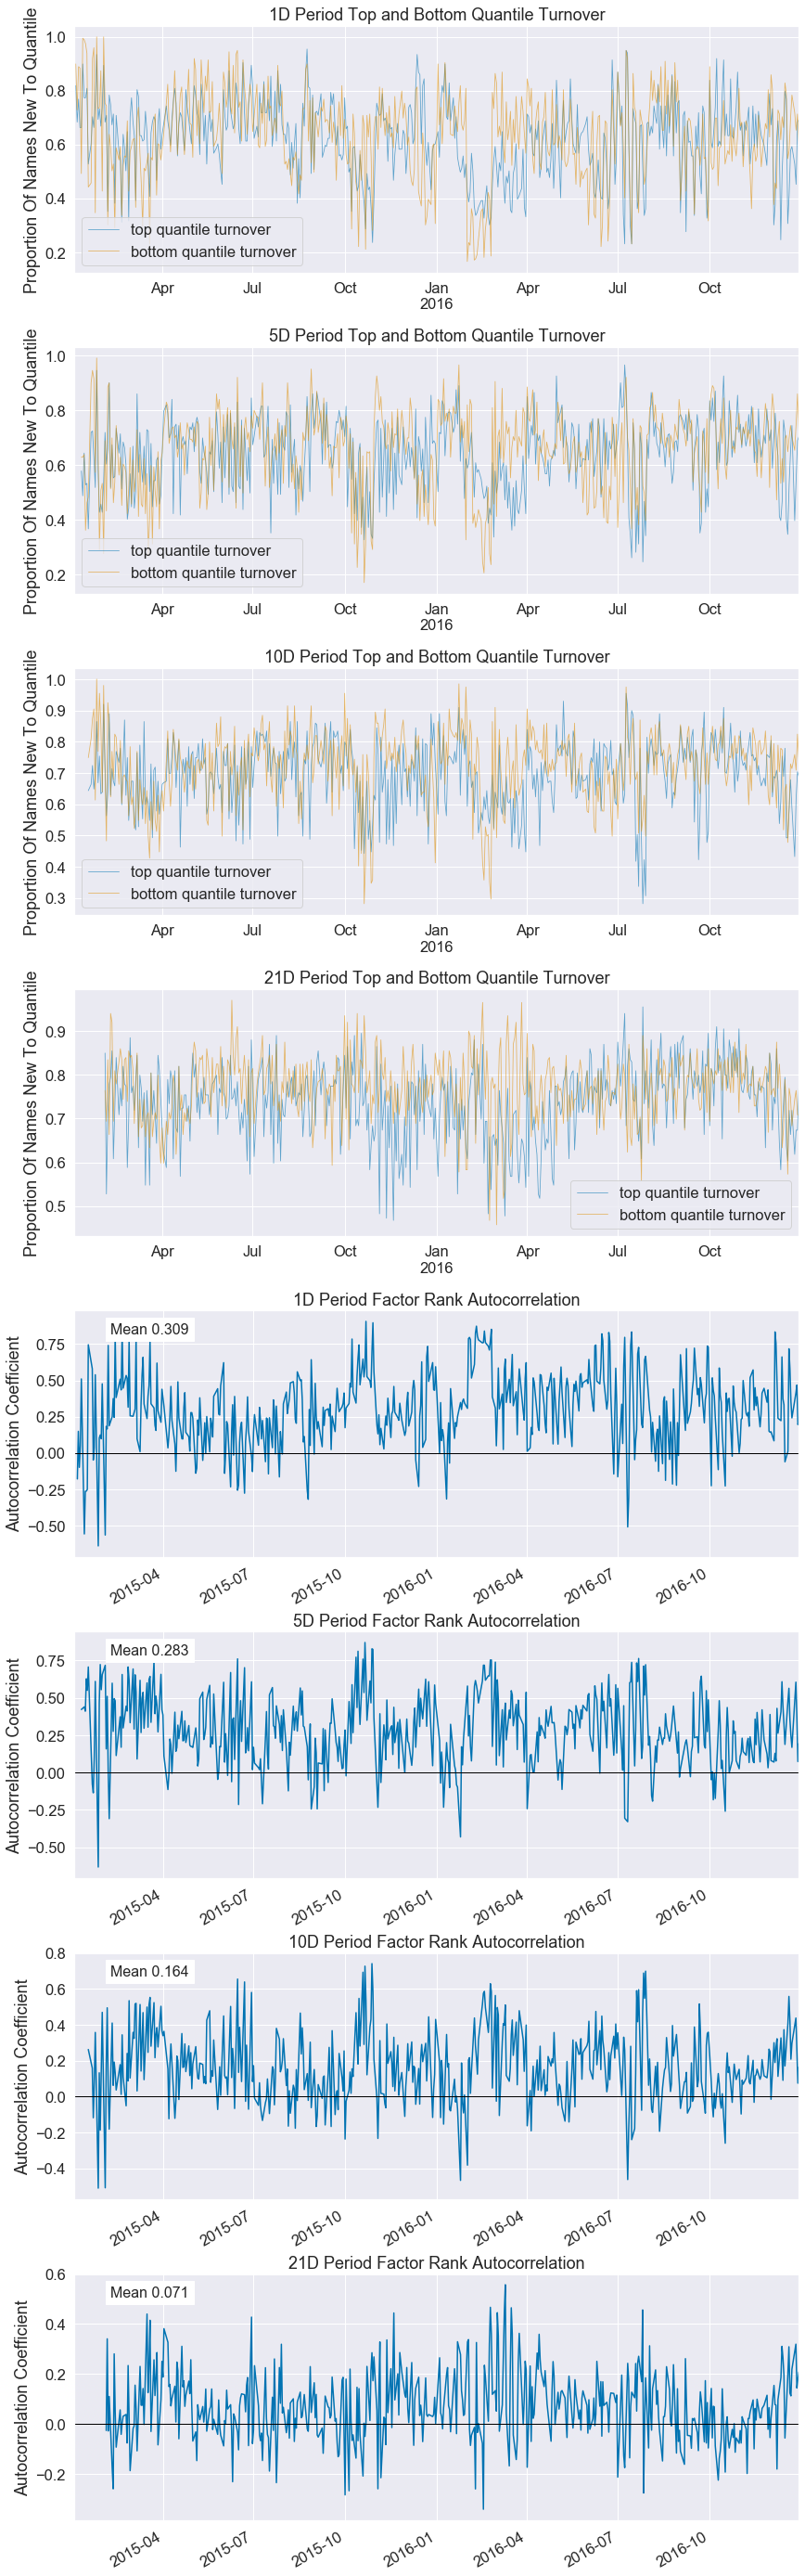

In [348]:
create_full_tear_sheet(factor_data)

### CatBoost

#### Select Parameters

In [58]:
catboost_ic_avg = pd.read_hdf('data/model_tuning.h5', 'catboost/ic_avg')
catboost_ic_avg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84 entries, 0 to 83
Data columns (total 7 columns):
lookahead            84 non-null int64
train_length         84 non-null int64
test_length          84 non-null int64
max_depth            84 non-null int64
min_child_samples    84 non-null int64
boost_rounds         84 non-null int64
ic                   84 non-null float64
dtypes: float64(1), int64(6)
memory usage: 5.2 KB


In [59]:
def get_cb_params(data, t=5, best=0):
    param_cols = scope_params[1:] + catboost_train_params + ['boost_rounds']
    df = data[data.lookahead==t].sort_values('ic', ascending=False).iloc[best]
    return df.loc[param_cols]

In [65]:
def get_cb_key(t, p):
    key = f'{t}/{int(p.train_length)}/{int(p.test_length)}/'
    return key + f'{int(p.max_depth)}/{int(p.min_child_samples)}'

In [60]:
best_params = get_cb_params(catboost_ic_avg, t=1, best=0)
best_params

train_length         1134.0
test_length            63.0
max_depth               7.0
min_child_samples      20.0
boost_rounds          300.0
Name: 20, dtype: float64

In [68]:
def select_cb_ic(params, ic_data, lookahead):
    return ic_data.loc[(ic_data.lookahead == lookahead) &
                       (ic_data.train_length == params.train_length) &
                       (ic_data.test_length == params.test_length) &
                       (ic_data.max_depth == params.max_depth) &
                       (ic_data.min_child_samples == params.min_child_samples)].set_index('date')

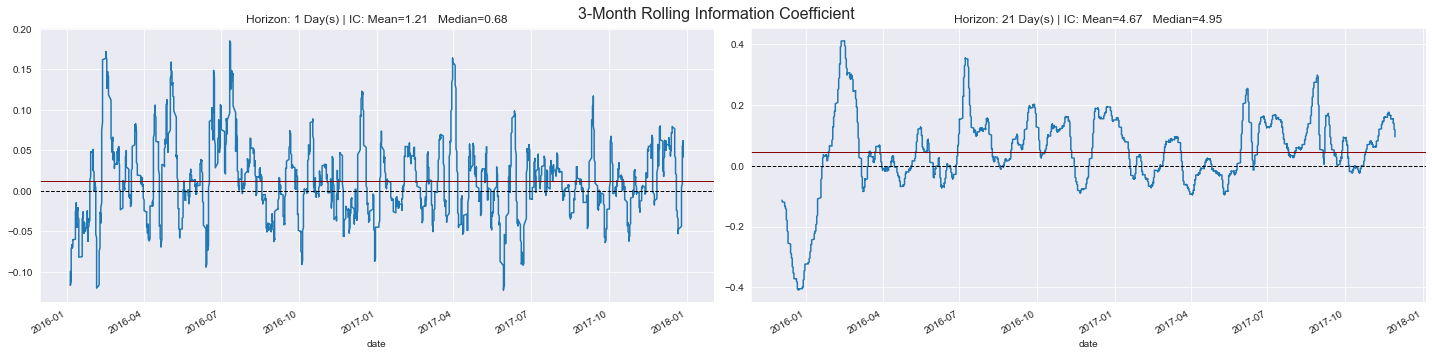

In [69]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes = axes.flatten()
for i, t in enumerate([1, 21]):
    params = get_cb_params(catboost_ic_avg, t=t)
    data = select_cb_ic(params, catboost_ic, lookahead=t).sort_index()
    rolling = data.rolling(63).ic.mean().dropna()
    avg = data.ic.mean()
    med = data.ic.median()
    rolling.plot(ax=axes[i], title=f'Horizon: {t} Day(s) | IC: Mean={avg*100:.2f}   Median={med*100:.2f}')
    axes[i].axhline(avg, c='darkred', lw=1)
    axes[i].axhline(0, ls='--', c='k', lw=1)

fig.suptitle('3-Month Rolling Information Coefficient', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.92)
fig.savefig('figures/rolling_ic_cb', dpi=300);

#### Get Predictions

In [ ]:
lookahead = 1
topn = 10
for best in range(topn):
    best_params = get_cb_params(catboost_ic_avg, t=lookahead, best=best)
    key = get_cb_key(lookahead, best_params)
    rounds = str(int(best_params.boost_rounds))
    if best == 0:
        best_predictions = pd.read_hdf('data/tuning_catboost.h5', 'predictions/' + key)
        best_predictions = best_predictions[rounds].to_frame(best)
    else:
        best_predictions[best] = pd.read_hdf('data/tuning_catboost.h5',
                                             'predictions/' + key)[rounds]
best_predictions = best_predictions.sort_index()

In [55]:
best_predictions.to_hdf('data/predictions.h5', f'catboost/train/{lookahead:02}')
best_predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 501310 entries, (A, 2015-01-02 00:00:00) to (ZION, 2016-12-30 00:00:00)
Data columns (total 10 columns):
0    501310 non-null float64
1    501310 non-null float64
2    501310 non-null float64
3    501310 non-null float64
4    501310 non-null float64
5    501310 non-null float64
6    501310 non-null float64
7    501310 non-null float64
8    501310 non-null float64
9    501310 non-null float64
dtypes: float64(10)
memory usage: 40.2+ MB


#### Get Trade Prices

Using next available prices.

In [116]:
def get_trade_prices(tickers):
    idx = pd.IndexSlice
    DATA_STORE = '../data/assets.h5'
    prices = (pd.read_hdf(DATA_STORE, 'quandl/wiki/prices').swaplevel().sort_index())
    prices.index.names = ['symbol', 'date']
    return (prices.loc[idx[tickers, '2015': '2017'], 'adj_open']
            .unstack('symbol')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [21]:
test_tickers = best_predictions.index.get_level_values('symbol').unique()

In [118]:
trade_prices = get_trade_prices(test_tickers)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 2015-01-02 00:00:00+00:00 to 2017-12-29 00:00:00+00:00
Columns: 995 entries, A to ZION
dtypes: float64(995)
memory usage: 5.7 MB


In [22]:
# only generate once to save time
trade_prices.to_hdf('data/model_tuning.h5', 'trade_prices/model_selection')

In [ ]:
trade_prices = pd.read_hdf('data/model_tuning.h5', 'trade_prices/model_selection')

In [23]:
factor = best_predictions.iloc[:, :5].mean(1).dropna().tz_localize('UTC', level='date').swaplevel()

#### Create AlphaLens Inputs

In [28]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21))

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


#### Summary Tearsheet

Quantiles Statistics


min       max      mean       std   count    count %
factor_quantile                                                           
1               -0.043323  0.007629 -0.002025  0.003269  100296  20.006822
2               -0.013078  0.010640 -0.000747  0.002936  100247  19.997048
3               -0.008825  0.012310 -0.000009  0.002950  100223  19.992260
4               -0.008289  0.017452  0.000698  0.003072  100247  19.997048
5               -0.007450  0.052497  0.002109  0.003811  100296  20.006822

Returns Analysis


1D     5D    10D    21D
Ann. alpha                                      0.176  0.078  0.045  0.037
beta                                            0.089  0.152  0.192  0.198
Mean Period Wise Return Top Quantile (bps)      5.884  3.375  2.742  2.496
Mean Period Wise Return Bottom Quantile (bps)  -6.282 -3.603 -2.240 -1.946
Mean Period Wise Spread (bps)                  12.165  6.951  4.946  4.408

Information Analysis


1D     5D    10D    21D
IC Mean           0.020  0.021  0.022  0.034
IC Std.           0.126  0.136  0.141  0.140
Risk-Adjusted IC  0.162  0.158  0.156  0.246
t-stat(IC)        3.638  3.545  3.501  5.515
p-value(IC)       0.000  0.000  0.001  0.000
IC Skew           0.065  0.249  0.246  0.087
IC Kurtosis       0.970  1.544  0.567  0.740

Turnover Analysis


10D     1D    21D     5D
Quantile 1 Mean Turnover   0.721  0.634  0.770  0.654
Quantile 2 Mean Turnover   0.779  0.751  0.790  0.756
Quantile 3 Mean Turnover   0.783  0.763  0.791  0.769
Quantile 4 Mean Turnover   0.777  0.752  0.795  0.756
Quantile 5 Mean Turnover   0.695  0.622  0.738  0.640

1D     5D    10D    21D
Mean Factor Rank Autocorrelation  0.309  0.283  0.164  0.071

<Figure size 432x288 with 0 Axes>

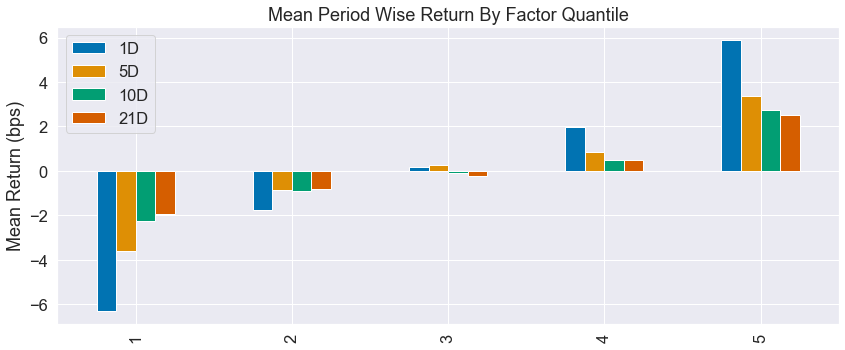

In [29]:
create_summary_tear_sheet(factor_data)

Quantiles Statistics


min       max      mean       std   count    count %
factor_quantile                                                           
1               -0.043323  0.007629 -0.002025  0.003269  100296  20.006822
2               -0.013078  0.010640 -0.000747  0.002936  100247  19.997048
3               -0.008825  0.012310 -0.000009  0.002950  100223  19.992260
4               -0.008289  0.017452  0.000698  0.003072  100247  19.997048
5               -0.007450  0.052497  0.002109  0.003811  100296  20.006822

Returns Analysis


1D     5D    10D    21D
Ann. alpha                                      0.176  0.078  0.045  0.037
beta                                            0.089  0.152  0.192  0.198
Mean Period Wise Return Top Quantile (bps)      5.884  3.375  2.742  2.496
Mean Period Wise Return Bottom Quantile (bps)  -6.282 -3.603 -2.240 -1.946
Mean Period Wise Spread (bps)                  12.165  6.951  4.946  4.408

<Figure size 432x288 with 0 Axes>

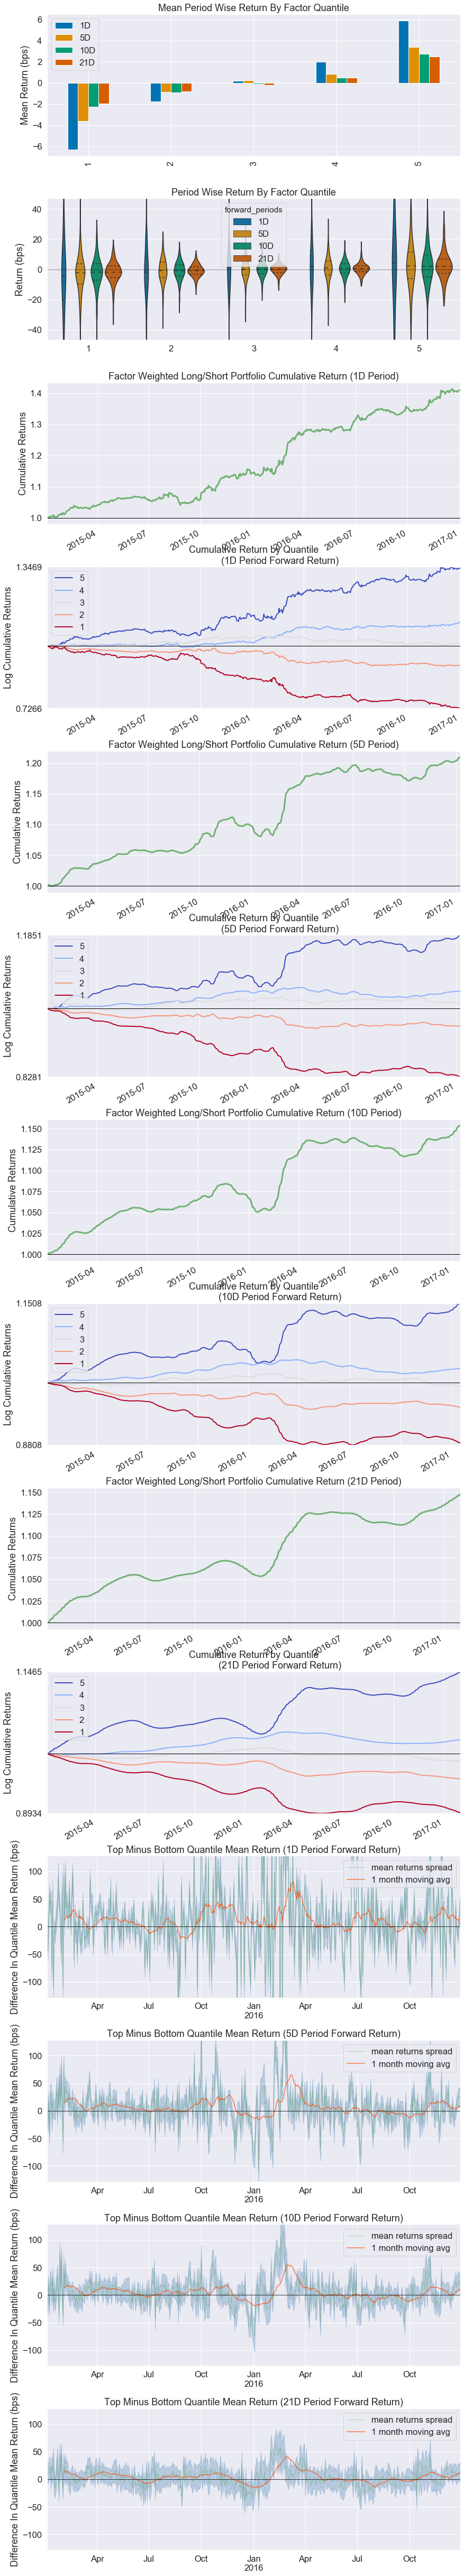

Information Analysis


1D     5D    10D    21D
IC Mean           0.020  0.021  0.022  0.034
IC Std.           0.126  0.136  0.141  0.140
Risk-Adjusted IC  0.162  0.158  0.156  0.246
t-stat(IC)        3.638  3.545  3.501  5.515
p-value(IC)       0.000  0.000  0.001  0.000
IC Skew           0.065  0.249  0.246  0.087
IC Kurtosis       0.970  1.544  0.567  0.740

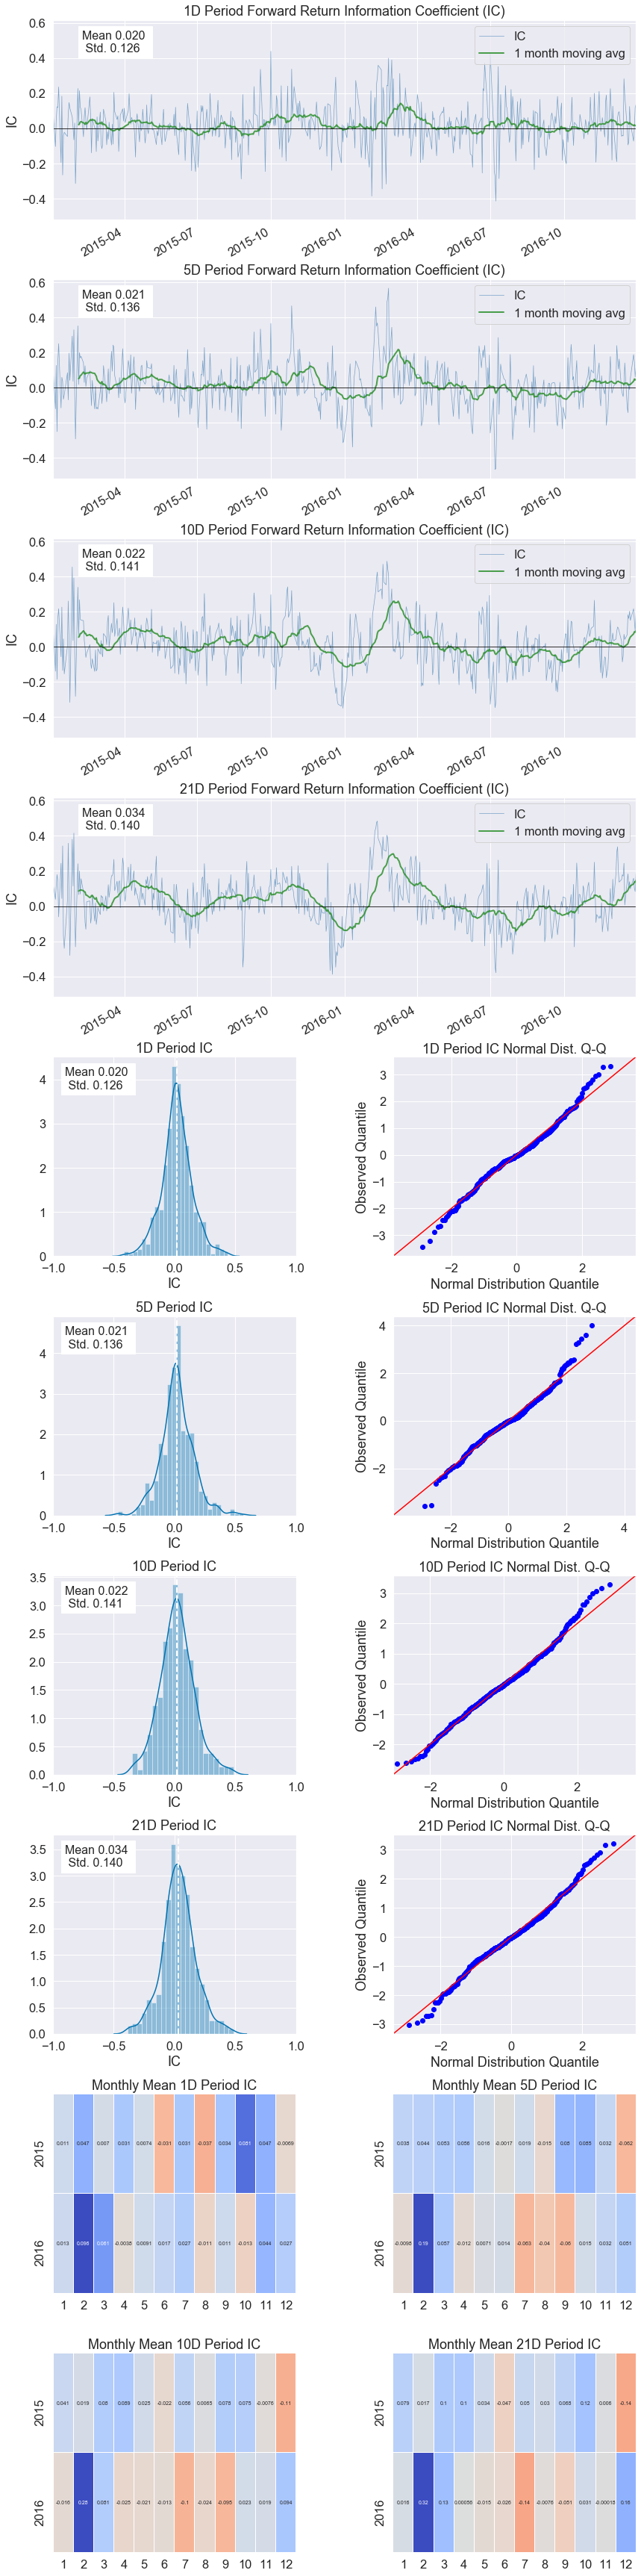

Turnover Analysis


10D     1D    21D     5D
Quantile 1 Mean Turnover   0.721  0.634  0.770  0.654
Quantile 2 Mean Turnover   0.779  0.751  0.790  0.756
Quantile 3 Mean Turnover   0.783  0.763  0.791  0.769
Quantile 4 Mean Turnover   0.777  0.752  0.795  0.756
Quantile 5 Mean Turnover   0.695  0.622  0.738  0.640

1D     5D    10D    21D
Mean Factor Rank Autocorrelation  0.309  0.283  0.164  0.071

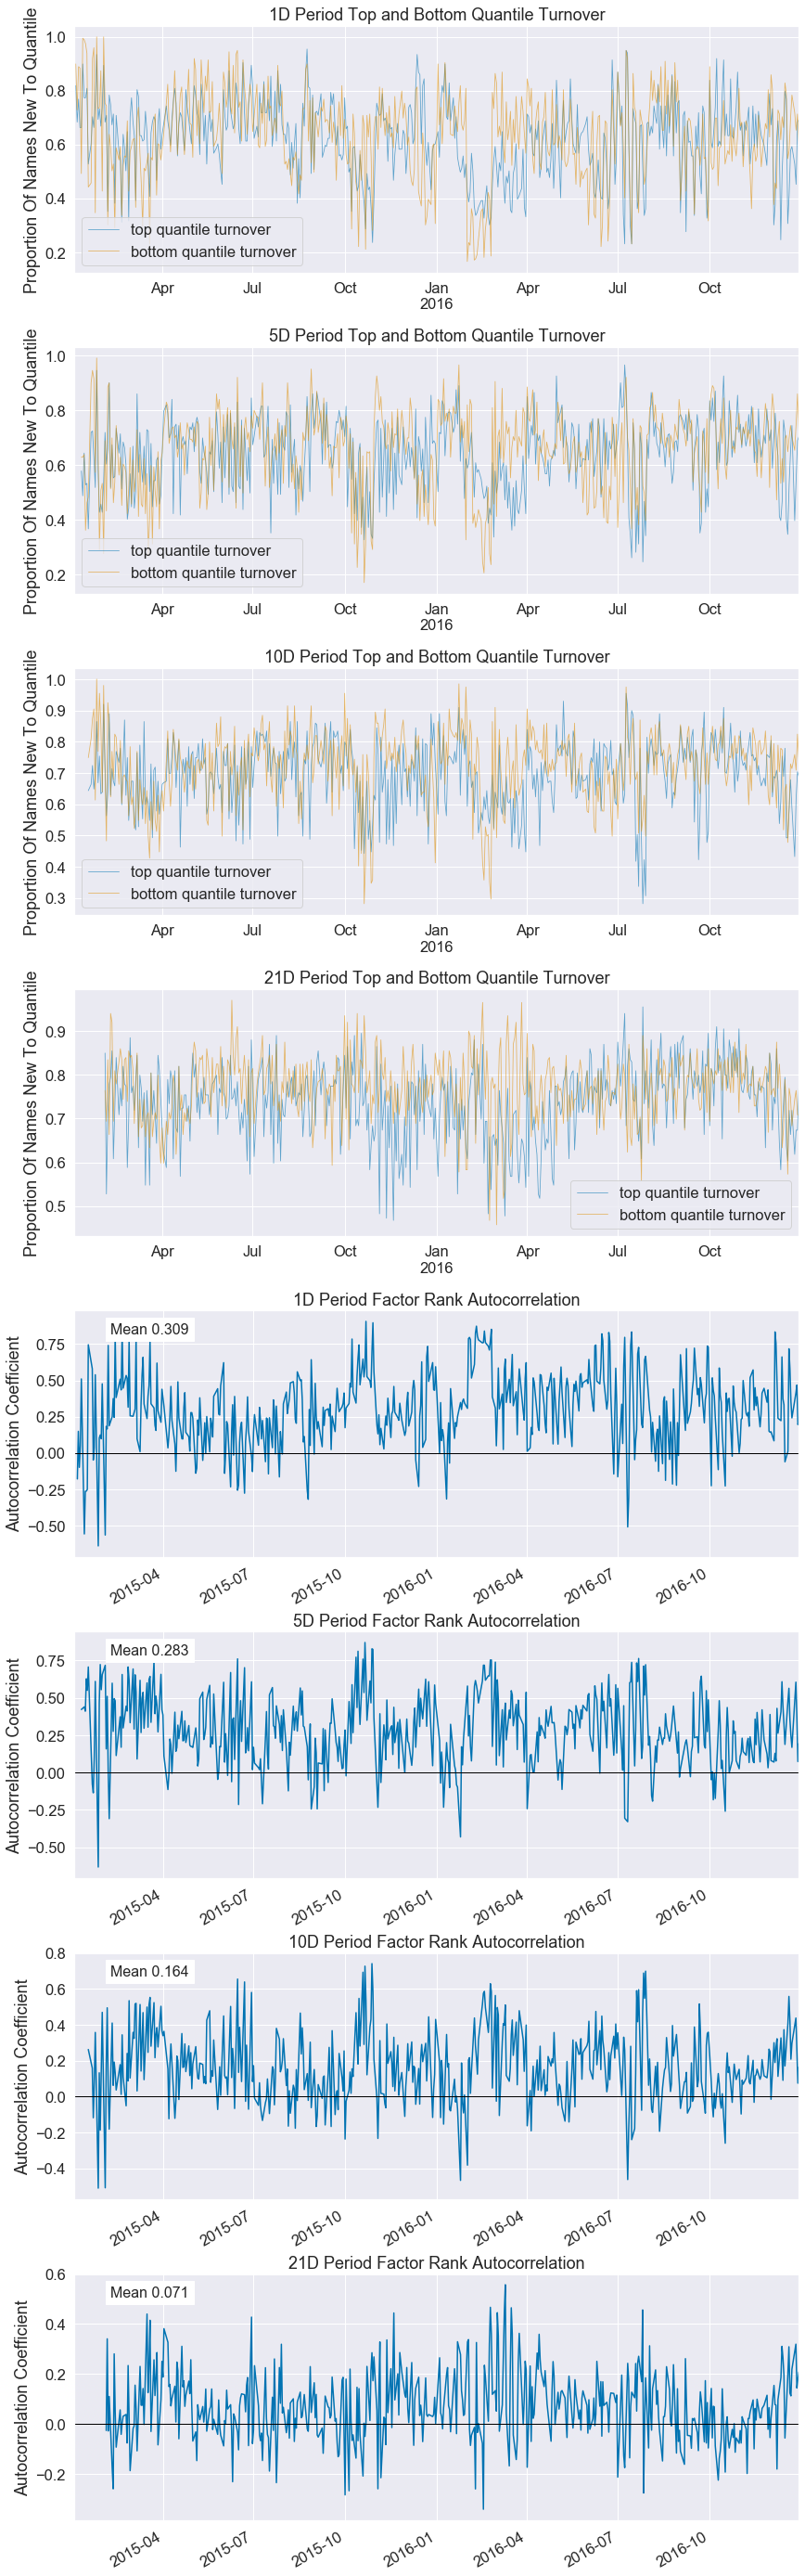

In [348]:
create_full_tear_sheet(factor_data)

## Generate predictions

### Model Configuration

In [16]:
base_params = dict(boosting='gbdt',
                   objective='regression',
                   verbose=-1)

categoricals = ['year', 'month', 'sector', 'weekday']

In [17]:
lookahead = 1
store = Path('data/predictions.h5')

### Get Data

In [18]:
data = pd.read_hdf('data/data.h5', 'model_data').sort_index()
labels = sorted(data.filter(like='_fwd').columns)
features = data.columns.difference(labels).tolist()
label = f'r{lookahead:02}_fwd'
data = data.loc[idx[:, '2010':], features + [label]].dropna()
for feature in categoricals:
    data[feature] = pd.factorize(data[feature], sort=True)[0]

In [19]:
lgb_data = lgb.Dataset(data=data[features],
                       label=data[label],
                       categorical_feature=categoricals,
                       free_raw_data=False)

### Generate predictions

In [ ]:
for position in range(10):
    params = get_params(daily_ic_avg,
                    t=lookahead,
                    best=position)
    
    params = params.to_dict()
    
    for p in ['min_data_in_leaf', 'num_leaves']:
        params[p] = int(params[p])
    train_length = int(params.pop('train_length'))
    test_length = int(params.pop('test_length'))
    num_boost_round = int(params.pop('boost_rounds'))
    params.update(base_params)

    print(f'\nPosition: {position:02}')

    n_splits = int(1 * YEAR / test_length)
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              test_period_length=test_length,
                              lookahead=lookahead,
                              train_period_length=train_length)

    predictions = []
    start = time()
    for i, (train_idx, test_idx) in enumerate(cv.split(X=data), 1):
        print(i, end=' ', flush=True)
        lgb_train = lgb_data.subset(train_idx.tolist()).construct()

        model = lgb.train(params=params,
                          train_set=lgb_train,
                          num_boost_round=num_boost_round,
                          verbose_eval=False)

        test_set = data.iloc[test_idx, :]
        y_test = test_set.loc[:, label].to_frame('y_test')
        y_pred = model.predict(test_set.loc[:, model.feature_name()])
        predictions.append(y_test.assign(prediction=y_pred))

    if position == 0:
        test_predictions = (pd.concat(predictions)
                            .rename(columns={'prediction': position}))
    else:
        test_predictions[position] = pd.concat(predictions).prediction

by_day = test_predictions.groupby(level='date')
for position in range(10):
    if position == 0:
        ic_by_day = by_day.apply(lambda x: spearmanr(x.y_test, x[position])[0]).to_frame()
    else:
        ic_by_day[position] = by_day.apply(lambda x: spearmanr(x.y_test, x[position])[0])
print(ic_by_day.describe())
ic_by_day.to_csv(f'ic_by_day_{lookahead:02}.csv')

key = f'{lookahead:02}'
test_predictions.to_hdf(store, 'test/' + key)

### AlphaLens Analysis

#### Prepare Factor Data

In [7]:
t = 1
idx = pd.IndexSlice
factor = (pd.read_hdf('data/predictions.h5', f'test/{t:02}')
          .drop('y_test', axis=1)
          .iloc[:, :5]
          .mean(1)
          .sort_index()
          .dropna()
          .tz_localize('UTC', level='date')
          .swaplevel())

In [13]:
dates = factor.index.get_level_values('date')
dates.min(), dates.max()

(Timestamp('2015-12-29 00:00:00+0000', tz='UTC'),
 Timestamp('2017-12-28 00:00:00+0000', tz='UTC'))

In [8]:
factor.head()

date                       symbol
2015-12-29 00:00:00+00:00  A        -0.003283
2015-12-30 00:00:00+00:00  A        -0.002505
2015-12-31 00:00:00+00:00  A        -0.000510
2016-01-04 00:00:00+00:00  A        -0.000549
2016-01-05 00:00:00+00:00  A         0.000030
dtype: float64

#### Select next available trade prices

Using next available prices.

In [10]:
tickers = factor.index.get_level_values('symbol').unique()

In [11]:
trade_prices = get_trade_prices(tickers)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 2015-01-02 to 2017-12-29
Columns: 995 entries, A to ZION
dtypes: float64(995)
memory usage: 5.7 MB


#### Get AlphaLens Inputs

In [ ]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21))
factor_data.sort_index().info()

#### Summary Tearsheet

In [ ]:
create_summary_tear_sheet(factor_data)

#### Full Tearsheet

In [ ]:
create_full_tear_sheet(factor_data,
                       long_short=True, 
                       group_neutral=False, 
                       by_group=True)